In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader,ConcatDataset

import matplotlib.pyplot as plt
import time
import copy
import os
import PIL

batch_size = 8
learning_rate = 1e-3
use_cuda = True
dir = '/content/drive/MyDrive/Colab Notebooks/decks'

In [3]:
from PIL import Image  #show one example of image

image1 = Image.open('/content/drive/MyDrive/Colab Notebooks/decks/train/1/deathwish_deck_57.jpg')
image2 = Image.open('/content/drive/MyDrive/Colab Notebooks/decks/train/2/powell_deck_65.jpg')
image3 = Image.open('/content/drive/MyDrive/Colab Notebooks/decks/train/3/santa_cruze_deck_129.jpg')

In [25]:
padding_size = 500
def padding_to_size(image: PIL.Image.Image) -> PIL.Image.Image:
  origin_size = transforms.functional.get_image_size(image)
  horizontal = (int)((padding_size - origin_size[0])/2)
  vertical = (int)((padding_size - origin_size[1])/2)
  new_size = [horizontal,vertical,horizontal,vertical]
  crop = transforms.Pad(padding=new_size)(image)
  crop = transforms.CenterCrop(size=500)(crop)
  #crop = transforms.Resize(size = 32)(crop)
  return crop

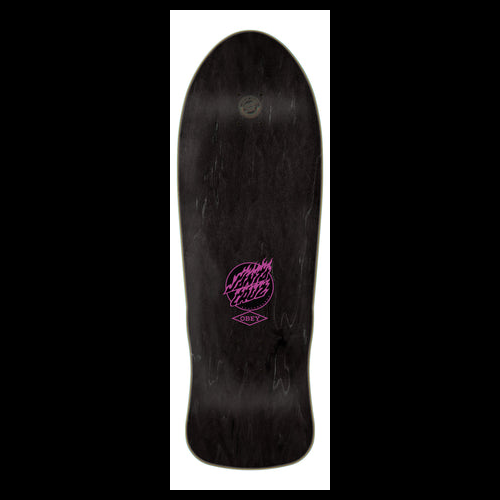

In [26]:
padding_to_size(image3)

In [28]:
data_transforms = {
    'training': transforms.Compose([
        transforms.Lambda(padding_to_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                              [0.229, 0.224,
                              0.225])]),
    'testing': transforms.Compose([
        transforms.Lambda(padding_to_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224,
                              0.225])])
}

train_dataset = datasets.ImageFolder(root = dir+'/train',transform=data_transforms['training'])
test_dataset = datasets.ImageFolder(root = dir+'/test',transform=data_transforms['testing'])


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
device

device(type='cuda', index=0)

In [30]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([8, 3, 500, 500])
out-size: torch.Size([3, 504, 4018])


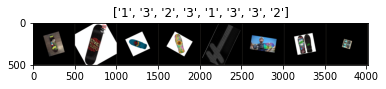

In [31]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [32]:
net = models.resnet50(pretrained=True)
net = net.cuda() if device else net

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() if use_cuda else net.fc

In [34]:
n_epochs = 20
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/20], Step [0/165], Loss: 4.8011
Epoch [1/20], Step [20/165], Loss: 4.7305


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [1/20], Step [40/165], Loss: 4.7494
Epoch [1/20], Step [60/165], Loss: 4.8144
Epoch [1/20], Step [80/165], Loss: 4.8844
Epoch [1/20], Step [100/165], Loss: 4.7049
Epoch [1/20], Step [120/165], Loss: 4.7280
Epoch [1/20], Step [140/165], Loss: 4.7687
Epoch [1/20], Step [160/165], Loss: 4.7020

train-loss: 4.7969, train-acc: 0.3037
validation loss: 4.6547, validation acc: 2.4194

Improvement-Detected, save-model
Epoch 2

Epoch [2/20], Step [0/165], Loss: 4.8173
Epoch [2/20], Step [20/165], Loss: 4.9007
Epoch [2/20], Step [40/165], Loss: 4.7080
Epoch [2/20], Step [60/165], Loss: 4.7154
Epoch [2/20], Step [80/165], Loss: 4.7515
Epoch [2/20], Step [100/165], Loss: 4.6259
Epoch [2/20], Step [120/165], Loss: 4.5663
Epoch [2/20], Step [140/165], Loss: 4.5592
Epoch [2/20], Step [160/165], Loss: 4.5337

train-loss: 4.7172, train-acc: 6.2263
validation loss: 4.5215, validation acc: 25.8065

Improvement-Detected, save-model
Epoch 3

Epoch [3/20], Step [0/165], Loss: 4.5206
Epoch [3/20], Step 

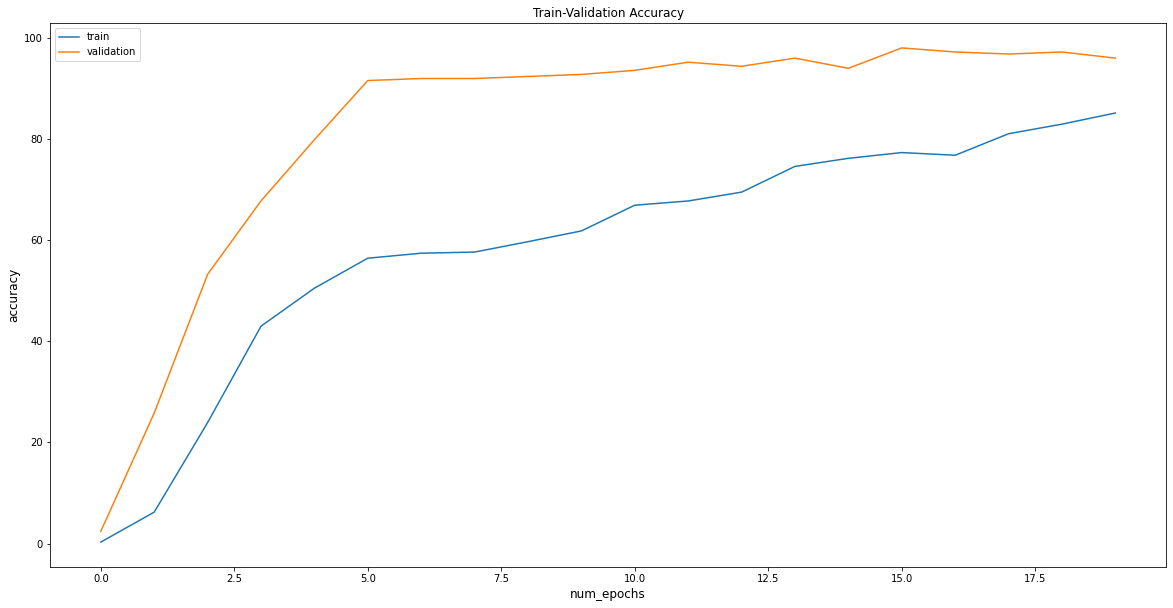

In [35]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [36]:
test_accuracy = 0

predictions = []
label_data = []

for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)
      log_ps = net(images)
      loss = criterion(log_ps,labels)
      ps = torch.exp(log_ps)
      top_ps, top_class = ps.topk(1, dim=1)
      matches = (top_class == labels.view(*top_class.shape)).type(
          torch.FloatTensor)
      test_batch_accuracy = matches.mean()
      test_accuracy += test_batch_accuracy
      predictions += top_class
      label_data += labels
    
    # Try to do similar things as validation to get the test accuracy
    # You also need to store the predictions and labels for all the test data, which will be used later
    # you could save them in predictions and label_data
print('Test Accuracy:', test_accuracy.item() / len(test_dataloader))

Test Accuracy: 0.8588709677419355
